In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
iris = load_iris()

In [3]:
feature_names_full = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
feature_names = ['sepal_width', 'petal_length']

In [4]:
df = pd.DataFrame(iris.data, columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
df['class'] = iris.target

In [5]:
df

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


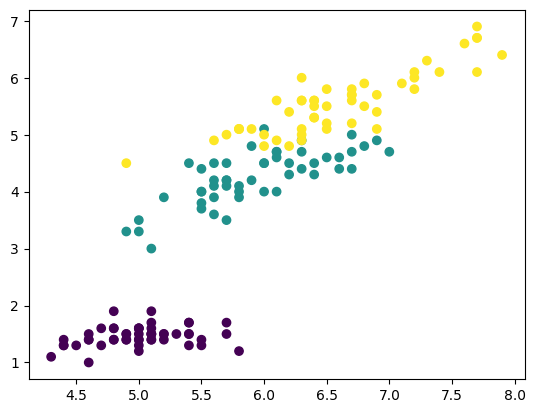

In [6]:
plt.scatter(df['sepal_length'], df['petal_length'], c = df['class'])

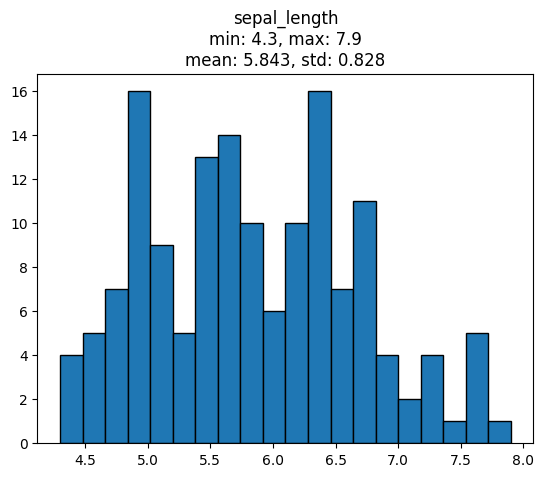

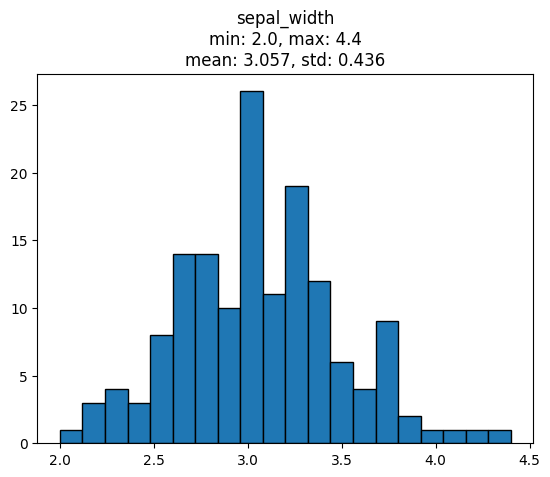

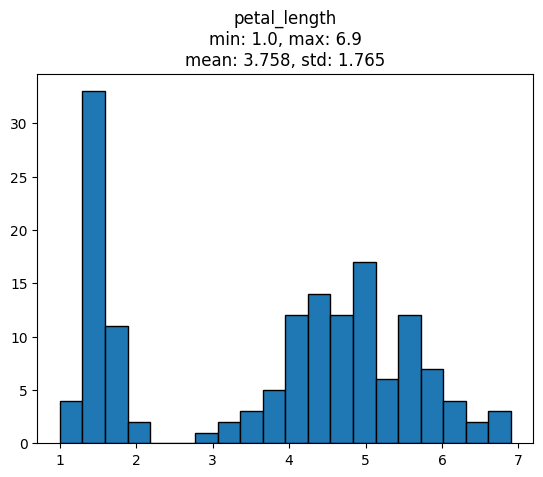

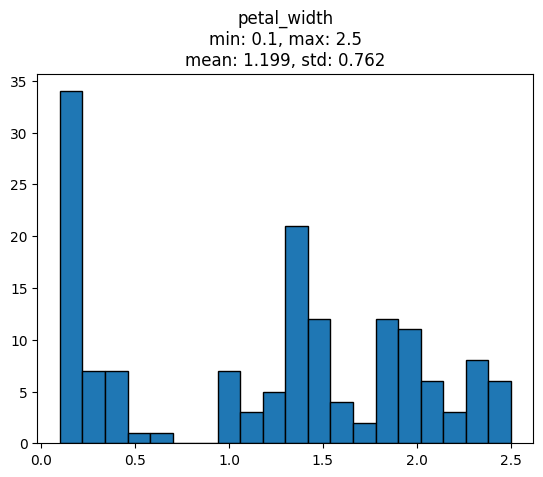

In [7]:
for name in df.columns[:4]:
    plt.hist(df[f'{name}'], bins = 20, edgecolor = 'black')
    plt.title(f'{name}\nmin: {df[f"{name}"].min()}, max: {df[f"{name}"].max()}\nmean: {df[f"{name}"].mean():.3f}, std: {df[f"{name}"].std():.3f}')
    plt.show()

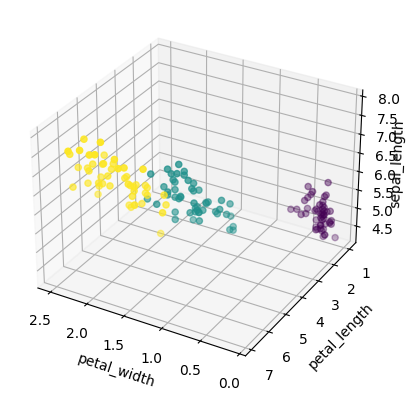

In [8]:
fig = plt.figure(0)
ax = fig.add_subplot(projection = '3d')
ax.view_init(elev = 30, azim = 120, roll = 0)

X, Y, Z = df['petal_width'], df['petal_length'], df['sepal_length']

ax.scatter(X, Y, Z, c = df['class'])
ax.set_xlabel('petal_width')
ax.set_ylabel('petal_length')
ax.set_zlabel('sepal_length')

ax.zaxis.labelpad = -4

plt.show()

In [9]:
df_max = df[feature_names].max(axis = 0)
df_min = df[feature_names].min(axis = 0)

df[feature_names] = (df[feature_names] - (df_max + df_min) / 2) # 데이터 중심 보정
df[feature_names] = df[feature_names] / df[feature_names].max(axis = 0) # 데이터 정규화

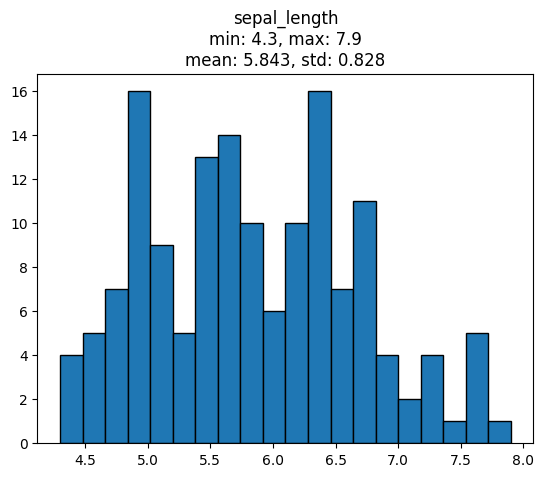

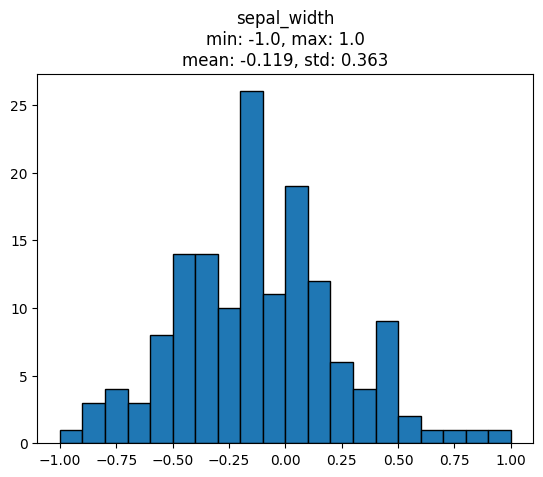

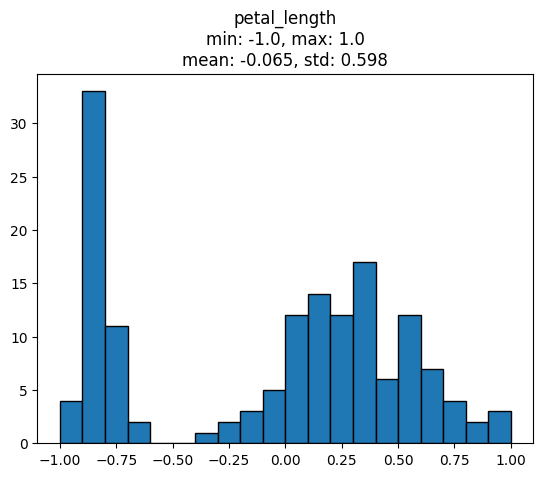

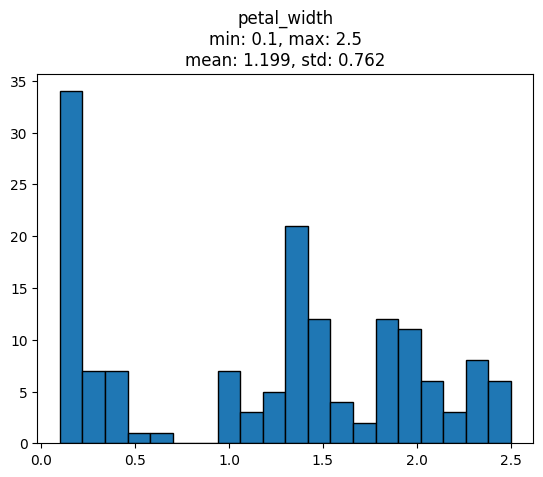

In [10]:
for name in df.columns[:4]:
    plt.hist(df[f'{name}'], bins = 20, edgecolor = 'black')
    plt.title(f'{name}\nmin: {df[f"{name}"].min()}, max: {df[f"{name}"].max()}\nmean: {df[f"{name}"].mean():.3f}, std: {df[f"{name}"].std():.3f}')
    plt.show()

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3, shuffle = True)

In [12]:
X, y = df[feature_names].to_numpy(), df['class'].to_numpy()

y = np.eye(3)[y.astype(np.int32)]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 2), (45, 2), (105, 3), (45, 3))

In [14]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = len(train_dataset), shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = True)

In [16]:
class NN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(NN, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, 16)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(16, 16)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(16, out_dim)
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        x1 = self.fc1(x)
        x1 = self.batch_norm1(x1)
        x1 = self.relu1(x1)
        
        x2 = self.fc2(x1)
        x2 = self.batch_norm2(x2)
        x2 = self.relu2(x2)
        
        x3 = self.fc3(x2)
        x3 = self.softmax(x3)
        
        return x3

In [17]:
model = NN(2, 3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)

In [18]:
train_loss, valid_loss = list(), list()
best_score = np.inf

for epoch in tqdm(range(3000), desc = 'Training...'):
    running_loss = int()
    for X, y in train_loader:
        optimizer.zero_grad()
        
        X, y = X.to(device), y.to(device)
        output = model(X)
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss.append(running_loss)
    
    running_loss = int()
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            
            running_loss += loss.item()
        
        if best_score >= running_loss:
            torch.save(model.state_dict(), f'./db_model/Epoch_{epoch}_best_model.pth')
            best_score = running_loss
            
        valid_loss.append(running_loss)

Training...:   0%|          | 0/3000 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_5320\1390529546.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x3 = self.softmax(x3)


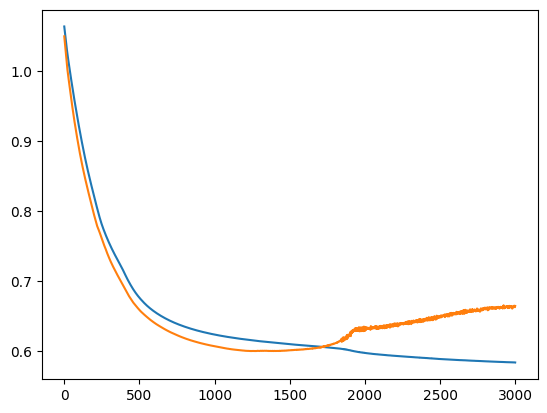

In [19]:
plt.plot(train_loss)
plt.plot(valid_loss)

In [25]:
model.load_state_dict(torch.load('./db_model/Epoch_1264_best_model.pth'))

<All keys matched successfully>

In [26]:
db_list = list()
for i in np.arange(-1, 1, 0.01):
    for j in np.arange(-1.0, 1.0, 0.01):
        db_list.append((i, j))
db_list = np.array(db_list)

In [27]:
db_pred = model(torch.tensor(db_list, dtype = torch.float32).to(device)).cpu().detach().numpy().argmax(1)

C:\Users\user\AppData\Local\Temp\ipykernel_5320\1390529546.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x3 = self.softmax(x3)


In [28]:
db_pred

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

Text(0, 0.5, 'petal_length')

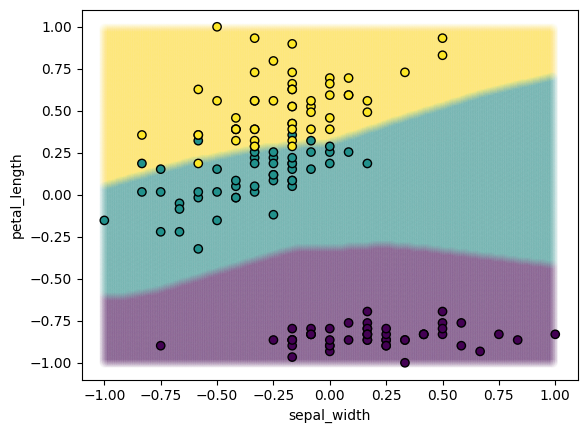

In [29]:
plt.scatter(db_list[:, 0], db_list[:, 1], c = db_pred, alpha = 0.03)
plt.scatter(df[feature_names[0]], df[feature_names[1]], c = df['class'], edgecolors = 'black')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])